# Correct sophronia hits with new map

Lets apply the corrections quickly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_master/IC/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.reco.corrections    import apply_all_correction, read_maps
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


import functions.functions_HE as func

In [ ]:
import traceback

def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
        failed          :       int
                                1 if the file failed to load, 0 otherwise.
    '''
    try: 
        tracks_df = load_dst(file_path, 'RECO', 'Events')
        return tracks_df, 0
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x, 1

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        total_failures  :       int
                                Total number of failed file loads.
    '''
    try:
        file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
        file_paths = [os.path.join(folder_path, f) for f in file_names][:500]

        with ProcessPoolExecutor() as executor:
            results = list(executor.map(load_single_file, file_paths))

        # Separate the results into respective lists
        tracks_list, failures = zip(*results)

        tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

        # Sum up the failures
        total_failures = sum(failures)

        return tracks, total_failures
    except Exception as e:
        print(f"An error occurred: {e}")
        traceback.print_exc()


In [3]:
def collect_maps( map_path : str,
                  apply_temp : bool,
                  norm_strat : NormStrategy):
    
    maps = read_maps(os.path.expandvars(map_path))
    get_coef = apply_all_correction( maps,
                                     apply_temp = apply_temp,
                                     norm_strat = norm_strat)
    
    return get_coef

In [4]:
data_path = 'data'
DATA_PATH = 'N100_LPR_MC'
RN = '250925'
CITY = 'prod'
TS = 'sophronia'
n100_dir = f'/{data_path}/halmazan/NEXT/{DATA_PATH}/{RN}/{CITY}/{TS}/ldc5/'
print(n100_dir)
holder, err = load_data_fast(n100_dir)

/data/halmazan/NEXT/N100_LPR_MC/250925/prod/sophronia/ldc5/


In [5]:
display(holder)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,84336000,1.686720e+14,0,-299.687968,-17.461967,1,-404.875,-62.575,0.0,0.0,240.474960,9.391304,439.018144,-1.0,0.001195,-1,-1.0
1,84336000,1.686720e+14,0,-299.687968,-17.461967,1,-389.325,-62.575,0.0,0.0,240.474960,7.304348,341.458576,-1.0,0.000912,-1,-1.0
2,84336000,1.686720e+14,0,-299.687968,-17.461967,1,-404.875,-48.025,0.0,0.0,240.474960,17.159420,802.156624,-1.0,0.002191,-1,-1.0
3,84336000,1.686720e+14,0,-299.687968,-17.461967,1,-404.875,-32.475,0.0,0.0,240.474960,5.159420,241.188976,-1.0,0.000656,-1,-1.0
4,84336000,1.686720e+14,0,-299.687968,-17.461967,1,-389.325,-48.025,0.0,0.0,240.474960,13.681160,639.557344,-1.0,0.001712,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45912708,90780082,1.815602e+14,0,198.517345,341.169115,1,335.525,337.725,0.0,0.0,691.420701,7.304348,292.773794,-1.0,0.001082,-1,-1.0
45912709,90780082,1.815602e+14,0,198.517345,341.169115,1,273.325,337.725,0.0,0.0,694.802608,6.376812,1000.105984,-1.0,0.002973,-1,-1.0
45912710,90780082,1.815602e+14,0,198.517345,341.169115,1,273.325,353.275,0.0,0.0,694.802608,5.507246,863.727851,-1.0,0.002717,-1,-1.0
45912711,90780082,1.815602e+14,0,198.517345,341.169115,1,288.875,322.175,0.0,0.0,694.802608,9.391304,1472.883327,-1.0,0.004387,-1,-1.0


In [6]:
from matplotlib.colors import LogNorm

holder['radius'] = (holder['X']**2 + holder['Y']**2)**0.5


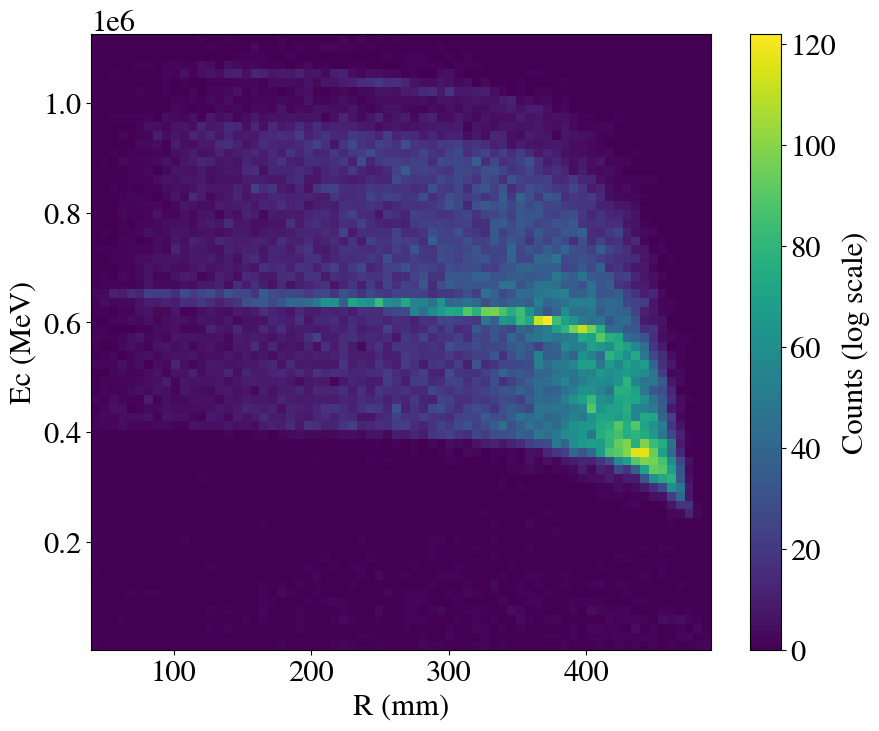

In [16]:
plt.hist2d(holder.groupby('event').radius.mean(), holder.groupby('event').E.sum(), 
            bins=70)
plt.xlabel('R (mm)')
plt.ylabel('Ec (MeV)')
plt.colorbar(label='Counts (log scale)')
plt.show()

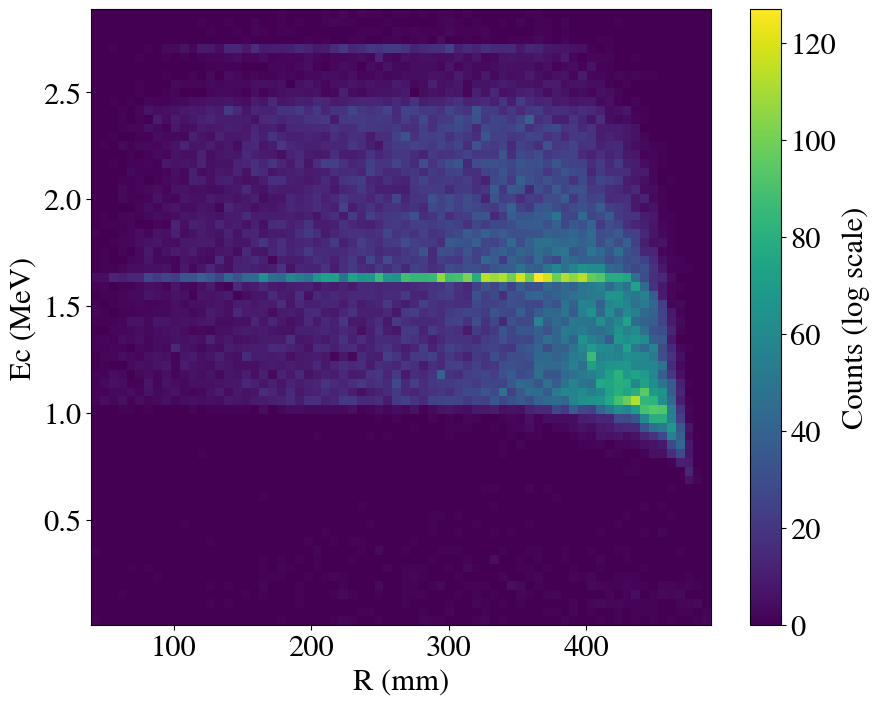

In [17]:
plt.hist2d(holder.groupby('event').radius.mean(), holder.groupby('event').Ec.sum(), bins = 70)           #range=[[0, 500], [1.5, 1.7]], bins=70)
plt.xlabel('R (mm)')
plt.ylabel('Ec (MeV)')
plt.colorbar(label='Counts (log scale)')
plt.show()

In [9]:
map_path = '/scratch/halmazan/NEXT/N100_LPR_MC/202510/lighttable'
map_file = '202510_map_full_1610.h5'
maps = read_maps(f'{map_path}/{map_file}')

In [10]:
get_coef = collect_maps( f'{map_path}/{map_file}',
                         False,
                         NormStrategy.kr)

In [11]:
get_all_coefs = get_coef(holder.X.values, holder.Y.values, holder.Z.values, holder.time.values)
holder['Ec'] = holder.E * get_all_coefs

In [12]:
holder['radius'] = (holder['X']**2 + holder['Y']**2)**0.5


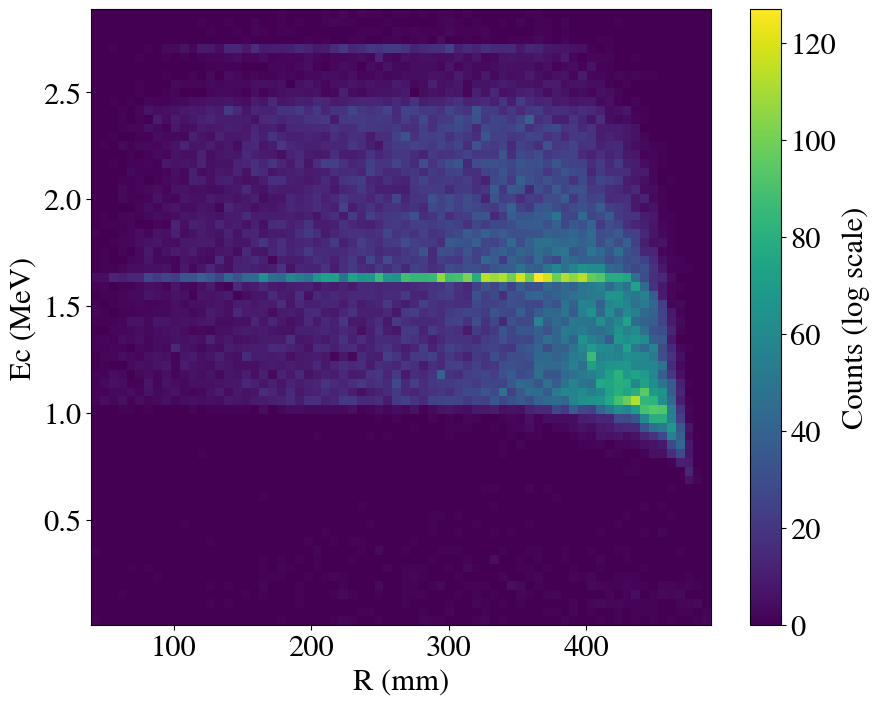

In [19]:
plt.hist2d(holder.groupby('event').radius.mean(), holder.groupby('event').Ec.sum(), bins = 70)
           #range=[[0, 500], [1.5, 1.7]], bins=70)
plt.xlabel('R (mm)')
plt.ylabel('Ec (MeV)')
plt.colorbar(label='Counts (log scale)')
plt.show()